# Stats from Goodreads Bookshelf

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
import json

In [2]:
csvPath = os.path.join(".", "goodreads_library_export.csv")

In [3]:
booklist = pd.read_csv(csvPath)

booklist.insert(list(booklist).index("Date Read"), "Year Read", 
                [int(i[:4]) if str(i).find("/") != -1 else -1 for i in booklist["Date Read"]],
                True)
booklist.insert(list(booklist).index("Date Read"), "Month Read", 
                [int(i[5:7]) if str(i).find("/") != -1 else -1 for i in booklist["Date Read"]], 
                True)
booklist.insert(list(booklist).index("Date Read"), "Day Read", 
                [int(i[8:]) if str(i).find("/") != -1 else -1 for i in booklist["Date Read"]], 
                True)

print(booklist.dtypes)


Book Id                         int64
Title                          object
Author                         object
Author l-f                     object
Additional Authors             object
ISBN                           object
ISBN13                         object
My Rating                       int64
Average Rating                float64
Publisher                      object
Binding                        object
Number of Pages               float64
Year Published                float64
Original Publication Year     float64
Year Read                       int64
Month Read                      int64
Day Read                        int64
Date Read                      object
Date Added                     object
Bookshelves                    object
Bookshelves with positions     object
Exclusive Shelf                object
My Review                     float64
Spoiler                       float64
Private Notes                 float64
Read Count                      int64
Owned Copies

### Filtering

In [4]:
read = booklist[booklist["Exclusive Shelf"] == "read"].reset_index(drop=True)
to_read = booklist[booklist["Exclusive Shelf"] == "to-read"].reset_index(drop=True)
reading = booklist[booklist["Exclusive Shelf"] == "currently-reading"].reset_index(drop=True)


# Books by year


Date Read
2021         54
2023         41
2022         37
2020         36
2024         17
dtype: int64


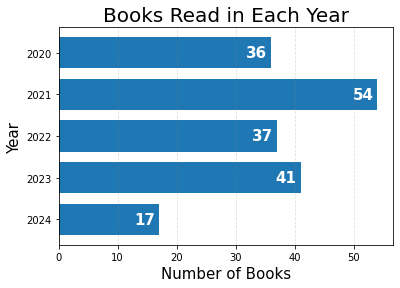

In [5]:
byYearRead = read[["Title","Date Read"]]
byYearRead = byYearRead[byYearRead["Date Read"] == byYearRead["Date Read"]]
byYearRead["Date Read"] = [int(str(x)[0:4]) for x in byYearRead["Date Read"]]
x = np.arange(byYearRead["Date Read"].max(), byYearRead["Date Read"].min()-1,-1)

countMap = byYearRead.value_counts(subset=["Date Read"])

bar_fig, bar_ax = plt.subplots()

bar_ax.set_title("Books Read in Each Year", fontsize=20)
bar_ax.set_xlabel("Number of Books", fontsize=15)
years = [str(i) for i in x]
counts = [countMap[i] for i in x]
print(byYearRead.value_counts(subset=["Date Read"]))

rects = bar_ax.barh(years, counts, align="center", height=0.75)
bar_ax.bar_label(rects, counts, padding=-25, color="white", fontweight="bold", fontsize=15)

bar_ax.xaxis.grid(True, linestyle="--", which="major", color="grey", alpha=0.25)
bar_ax.set_ylabel("Year", fontsize=15)
pass

# General Scatterplot

In [6]:
cols = [i for i in list(booklist) if pd.api.types.is_numeric_dtype(booklist[i])]

listSelection = {
    "read": widgets.Checkbox(
        value=True,
        description="read",
        disabled=False,
        indent=False
    ),
    "toRead": widgets.Checkbox(
        value=False,
        description="to read",
        disabled=False,
        indent=False
    ),
    "continueReading": widgets.Checkbox(
        value=False,
        description="continue reading",
        disabled=False,
        indent=False
    )
}
# selectionBox = widgets.HBox(children=listSelection)

axisChoices = [
    widgets.Dropdown(
        options=cols,
        value=cols[0],
        description="X axis = ",
        disabled=False
    ),
    widgets.Dropdown(
        options=cols,
        value=cols[0],
        description="Y axis = ",
        disabled=False
    ),
]

# axisBox = widgets.VBox(children=axisChoices)

# display(selectionBox)
# display(axisBox)

@widgets.interact(readChoice=listSelection["read"], 
                  toReadChoice=listSelection["toRead"], 
                  continueReadingChoice=listSelection["continueReading"],
                  xAxis=axisChoices[0],
                  yAxis=axisChoices[1])
def on_change(readChoice, toReadChoice, continueReadingChoice, xAxis, yAxis):
    print((readChoice,toReadChoice,continueReadingChoice))
    print(xAxis, yAxis)
    scatter_fig, scatter_plt = plt.subplots()
    
    plotList = []
    if readChoice: plotList.append(read)
    if toReadChoice: plotList.append(to_read)
    if continueReadingChoice: plotList.append(reading)
    if(len(plotList) == 0): plotList.append(booklist)
    chosenList = pd.concat(plotList, ignore_index=True, sort=False)
    
    scatter_plt.scatter(x=chosenList[xAxis], y=chosenList[yAxis])
# outputs = widgets.interact(on_change, read=listSelection["read"])

# for i in listSelection: i.observe(on_change, names="value") 

interactive(children=(Checkbox(value=True, description='read', indent=False), Checkbox(value=False, descriptio…

In [7]:

histchoice = widgets.Dropdown(
        options=cols,
        value=cols[0],
        description="Value = ",
        disabled=False
    )

binSlider = widgets.IntSlider(
    value=7,
    min=3,
    max=100,
    step=1,
    description='Bin Count:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

@widgets.interact(readChoice=listSelection["read"], 
                  toReadChoice=listSelection["toRead"], 
                  continueReadingChoice=listSelection["continueReading"],
                  histChoice=histchoice,
                  binCount=binSlider)
def process_hist_choice(readChoice, toReadChoice, continueReadingChoice, histChoice, binCount):
    hist_fig, hist_plt = plt.subplots()
    
    plotList = []
    if readChoice: plotList.append(read)
    if toReadChoice: plotList.append(to_read)
    if continueReadingChoice: plotList.append(reading)
    if(len(plotList) == 0): plotList.append(booklist)
    chosenList = pd.concat(plotList, ignore_index=True, sort=False)
    
    hist_plt.hist([i for i in chosenList[histChoice] if i != -1], binCount)

interactive(children=(Checkbox(value=True, description='read', indent=False), Checkbox(value=False, descriptio…

## Using WikiData

In [8]:
import requests

def access_wikidata(query, search=True):
    endpoint = "https://www.wikidata.org/w/api.php"
    if search: 
        params = {
            "action": "wbsearchentities",
            "format": "json",
            "search": query,
            "language": "en"
        }
    else:
        params = {
            "action": "wbgetentities",
            "ids": query,
            "format": "json",
            "languages": "en"
        }
    try:
        return requests.get(endpoint, params=params)
    except:
        return "Error"

In [9]:
# test
data = access_wikidata("JRR Tolkien").json()
access_wikidata(data["search"][0]["id"], search=False).json()["entities"]["Q892"]["claims"]["P21"][0]["mainsnak"]["datavalue"]["value"]["id"]

'Q6581097'

In [10]:

def getGender(name):
    searchResults = access_wikidata(name)
    try: 
        searchResults = searchResults.json()
        firstResultPage = access_wikidata(searchResults["search"][0]["id"], search=False).json()
        gender = firstResultPage["entities"][searchResults["search"][0]["id"]]["claims"]["P21"][0]["mainsnak"]["datavalue"]["value"]["id"]
        gender = access_wikidata(gender, search=False).json()
        gender = gender["entities"][next(iter(gender["entities"]))]["labels"]["en"]["value"]
        return gender
    except: 
        return "Error"

# print("Starting...")
# uniqueAuthor = {}
# for i in read["Author"]:
#     i = " ".join(i.split())
#     if i in uniqueAuthor: continue
#     currGen = getGender(i)
#     print("%-*s %s" % (30, f"\"{i}\":", currGen))
#     uniqueAuthor[i] = currGen
    
# print("Done.")

In [11]:
# genderCounts = {}
# genderCounts["female"] = 0
# genderCounts["male"] = 0
# for i in uniqueAuthor:
#     if uniqueAuthor[i] not in genderCounts:
#         genderCounts[uniqueAuthor[i]] = 0
#     genderCounts[uniqueAuthor[i]] += 1
    

# pie_fig, pie_plt = plt.subplots()


# pie_plt.pie([genderCounts[i] for i in genderCounts], 
#             labels=list(genderCounts), 
#             radius=2.5, 
#             autopct = lambda p : str(round(p, 2)) + "%",
#             pctdistance = 0.9)

# print("Author Gender")
# print(genderCounts)

## General

In [12]:
uniqueAuthor = {}
for i in read["Author"]:
    i = " ".join(i.split())
    if i in uniqueAuthor: continue
    uniqueAuthor[i] = "gender"

authorInfo = {}
print("Fetching author info")
for author in uniqueAuthor:
    try:
        print(f"Attempting {author}... ", end="")
        search_results = access_wikidata(author).json()
        top_result = access_wikidata(search_results["search"][0]["id"], search=False).json()
        authorInfo[author] = top_result
        print("Done.")
    except: 
        authorInfo[author] = "Failed"
        print("Failed")
        
print("Done fetching")

Fetching author info
Attempting Anne Carson... Done.
Attempting Chuck Tingle... Done.
Attempting Ryka Aoki... Done.
Attempting Leslie Feinberg... Done.
Attempting Ryoko Kui... Done.
Attempting Mark Z. Danielewski... Done.
Attempting Katsuhiro Otomo... Done.
Attempting Terry Pratchett... Done.
Attempting Melanie Gillman... Done.
Attempting Donna Tartt... Done.
Attempting Madeline Miller... Done.
Attempting Becky Chambers... Done.
Attempting T.J. Klune... Done.
Attempting James Baldwin... Done.
Attempting André Aciman... Done.
Attempting Taylor Jenkins Reid... Done.
Attempting Erin Morgenstern... Done.
Attempting Amal El-Mohtar... Done.
Attempting Audre Lorde... Done.
Attempting Heinz Heger... Done.
Attempting Casey McQuiston... Done.
Attempting Hanya Yanagihara... Done.
Attempting Cam Marshall... Failed
Attempting Ocean Vuong... Done.
Attempting Matt Bors... Done.
Attempting N.D. Stevenson... Done.
Attempting Maia Kobabe... Done.
Attempting Scarlett Gale... Failed
Attempting Naomi Tucke

In [13]:
authorInfo["Becky Chamber"]

{'entities': {'Q20090453': {'pageid': 21760269,
   'ns': 0,
   'title': 'Q20090453',
   'lastrevid': 2224097146,
   'modified': '2024-08-09T23:21:45Z',
   'type': 'item',
   'id': 'Q20090453',
   'labels': {'en': {'language': 'en', 'value': 'Chuck Tingle'}},
   'descriptions': {'en': {'language': 'en',
     'value': 'anonymous American erotic writer'}},
   'aliases': {'en': [{'language': 'en', 'value': 'Dr. Chuck Tingle'}]},
   'claims': {'P31': [{'mainsnak': {'snaktype': 'value',
       'property': 'P31',
       'hash': 'ad7d38a03cdd40cdc373de0dc4e7b7fcbccb31d9',
       'datavalue': {'value': {'entity-type': 'item',
         'numeric-id': 5,
         'id': 'Q5'},
        'type': 'wikibase-entityid'},
       'datatype': 'wikibase-item'},
      'type': 'statement',
      'id': 'Q20090453$1A741949-5635-4C61-9F28-3D5F61FA7B33',
      'rank': 'normal'}],
    'P21': [{'mainsnak': {'snaktype': 'value',
       'property': 'P21',
       'hash': '20f35700b519779aa2caefeaf246304df3f22cc3',
     

In [19]:
from functools import cache

@cache
def translateID(id):
    idText = access_wikidata(id, search=False).json()
    return idText["entities"][next(iter(idText["entities"]))]["labels"]["en"]["value"]

def unpackWikidata(pageJson):
    if(pageJson == "Failed"): return "Failed"
    
    data = {}
    properties = pageJson["entities"][list(pageJson["entities"])[0]]["claims"]
    for i in properties:
#         s = json.dumps(properties[i])
#         q = json.dumps(json.loads(s), indent=2)
#         print(q)
        try:
            if(properties[i][0]["type"] == "statement"):
                value = properties[i][0]["mainsnak"]["datavalue"]["value"]
                if isinstance(value, str):
                    data[translateID(i)] = value
                else:
                    data[translateID(i)] = translateID(value["id"])
        except:
            pass
            
    return data
            
    
#     for id in list(spot):
#         print(translateID(id))


unpackedData = {}
for i in authorInfo:
    print(i)
    unpackedData[i] = unpackWikidata(authorInfo[i])
  

unpackedData

Anne Carson
Chuck Tingle
Ryka Aoki
Leslie Feinberg
Ryoko Kui
Mark Z. Danielewski
Katsuhiro Otomo
Terry Pratchett
Melanie Gillman
Donna Tartt
Madeline Miller
Becky Chambers
T.J. Klune
James Baldwin
André Aciman
Taylor Jenkins Reid
Erin Morgenstern
Amal El-Mohtar
Audre Lorde
Heinz Heger
Casey McQuiston
Hanya Yanagihara
Cam Marshall
Ocean Vuong
Matt Bors
N.D. Stevenson
Maia Kobabe
Scarlett Gale
Naomi Tucker
Ray Bradbury
Neil Gaiman
Bryan Lee O'Malley
Rachel Smythe
Keith Giffen
Frank Miller
Sarah Andersen
Matt Ruff
H.P. Lovecraft
Shelley Parker-Chan
Michelle Alexander
Daniel Keyes
Anthony Burgess
Malcolm X
Ernesto Che Guevara
Martha Wells
Ursula K. Le Guin
Robin Wall Kimmerer
Brandon Sanderson
Seanan McGuire
Ibram X. Kendi
Ernest Callenbach
Benjamin Hoff
Randall Munroe
Emily St. John Mandel
Sherman Alexie
Shirley Jackson
Philip K. Dick
Ian Fleming
William Golding
Andy Weir
William Gibson
Alan Weisman
Hermann Hesse
Haruki Murakami
James Riley
Alastair Reynolds
Susanna Clarke
Edward Abbey
Am

{'Anne Carson': {'VIAF ID': '110404294',
  'ISNI': '0000000121476276',
  'instance of': 'human',
  'place of birth': 'Toronto',
  'occupation': 'linguist',
  'award received': 'Guggenheim Fellowship',
  'GND ID': '122416309',
  'Library of Congress authority ID': 'n85370220',
  'Freebase ID': '/m/0ljpq',
  'country of citizenship': 'Canada',
  'notable work': 'Autobiography of Red',
  'CANTIC ID (former scheme)': 'a11080905',
  'employer': 'Princeton University',
  'given name': 'Anne',
  'Nationale Thesaurus voor Auteursnamen ID': '07236629X',
  'Perlentaucher ID': 'anne-carson',
  'Digitale Bibliotheek voor de Nederlandse Letteren author ID': 'cars003',
  'family name': 'Carson',
  'FAST ID': '169263',
  'Encyclopædia Britannica Online ID': 'biography/Anne-Carson',
  'member of': 'American Academy of Arts and Sciences',
  'NE.se ID': 'anne-carson',
  'SNAC ARK ID': 'w6qj8321',
  'Quora topic ID': 'Anne-Carson',
  'influenced by': 'Virginia Woolf',
  'National Library of Spain ID': 'X

In [20]:
unpackedData["Becky Chambers"]

{'instance of': 'human',
 'sex or gender': 'female',
 'occupation': 'science fiction writer',
 'Bibliothèque nationale de France ID': '17074715h',
 'Library of Congress authority ID': 'no2016015279',
 'VIAF ID': '169145541820896600334',
 'image': 'Becky Chambers.jpg',
 'Internet Speculative Fiction Database author ID': '217169',
 'ISNI': '0000000459730147',
 'Nationale Thesaurus voor Auteursnamen ID': '401251837',
 'place of birth': 'Southern California',
 'NooSFere author ID': '2147199065',
 'Commons category': 'Becky Chambers',
 'family name': 'Chambers',
 'Goodreads author ID': '8389735',
 'official website': 'https://www.otherscribbles.com',
 'sexual orientation': 'gay',
 'NL CR AUT ID': 'ola2017972290',
 'languages spoken, written or signed': 'English',
 'genre': 'science fiction',
 'notable work': 'The Long Way to a Small, Angry Planet',
 'nominated for': 'Otherwise Award',
 'Encyclopedia of Science Fiction ID': 'chambers_becky',
 'GND ID': '1128839989',
 'given name': 'Becky',
 

## Country

Author country of citizenship
{'Canada': 5, 'United States of America': 90, 'Japan': 4, 'United Kingdom': 23, 'Austria': 2, 'Failed': 4, 'German Empire': 1, 'Sweden': 1, 'Kingdom of Prussia': 2, 'Iran': 1, 'Colonial Nigeria': 1, 'United Kingdom of Great Britain and Ireland': 5, 'Poland': 1, 'Russian Socialist Federative Soviet Republic': 1, 'Pakistan': 1, 'Ireland': 1, 'Australia': 1, 'France': 1, 'Brazil': 1}


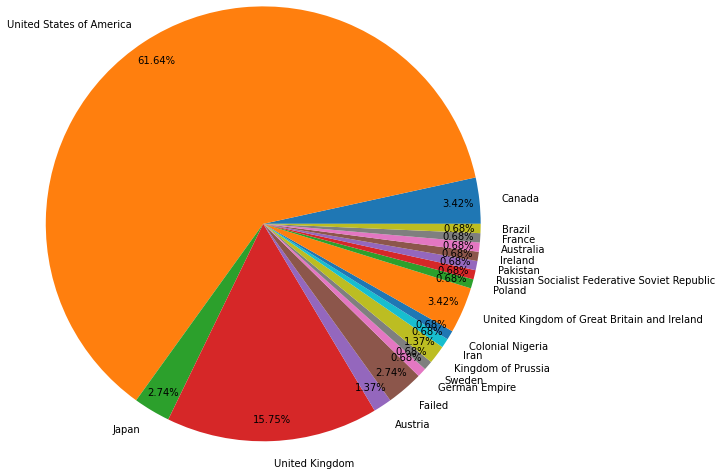

In [60]:
countryCounts = {}
attr = "country of citizenship"

for i in unpackedData:
    if unpackedData[i] == "Failed":
        if "Failed" not in countryCounts:
            countryCounts["Failed"] = 1
        else:
            countryCounts["Failed"] += 1
        continue
#     print(unpackedData[i]["country of citizenship"])
    if attr in unpackedData[i]:
        if unpackedData[i][attr] not in countryCounts: 
            countryCounts[unpackedData[i][attr]] = 1
        else:
            countryCounts[unpackedData[i][attr]] += 1
    

pie_fig, pie_plt = plt.subplots()


pie_plt.pie([countryCounts[i] for i in countryCounts], 
            labels=list(countryCounts), 
            radius=2.5, 
            autopct = lambda p : str(round(p, 2)) + "%",
            pctdistance = 0.9)

print("Author", attr)
print(countryCounts)

Author place of birth
{'Canada': 5, 'United States of America': 90, 'Japan': 4, 'United Kingdom': 23, 'Austria': 2, 'Failed': 4, 'German Empire': 1, 'Sweden': 1, 'Kingdom of Prussia': 2, 'Iran': 1, 'Colonial Nigeria': 1, 'United Kingdom of Great Britain and Ireland': 5, 'Poland': 1, 'Russian Socialist Federative Soviet Republic': 1, 'Pakistan': 1, 'Ireland': 1, 'Australia': 1, 'France': 1, 'Brazil': 1}


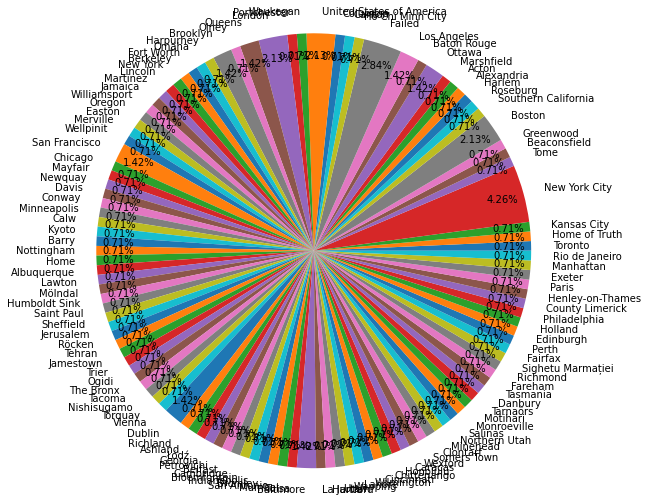

In [61]:
birthCounts = {}
attr = "place of birth"

for i in unpackedData:
    if unpackedData[i] == "Failed":
        if "Failed" not in birthCounts:
            birthCounts["Failed"] = 1
        else:
            birthCounts["Failed"] += 1
        continue
#     print(unpackedData[i]["country of citizenship"])
    if attr in unpackedData[i]:
        if unpackedData[i][attr] not in birthCounts: 
            birthCounts[unpackedData[i][attr]] = 1
        else:
            birthCounts[unpackedData[i][attr]] += 1
    

pie_fig, pie_plt = plt.subplots()


pie_plt.pie([birthCounts[i] for i in birthCounts], 
            labels=list(birthCounts), 
            radius=2.5, 
            autopct = lambda p : str(round(p, 2)) + "%",
            pctdistance = 0.9)

print("Author", attr)
print(countryCounts)

In [ ]:
f